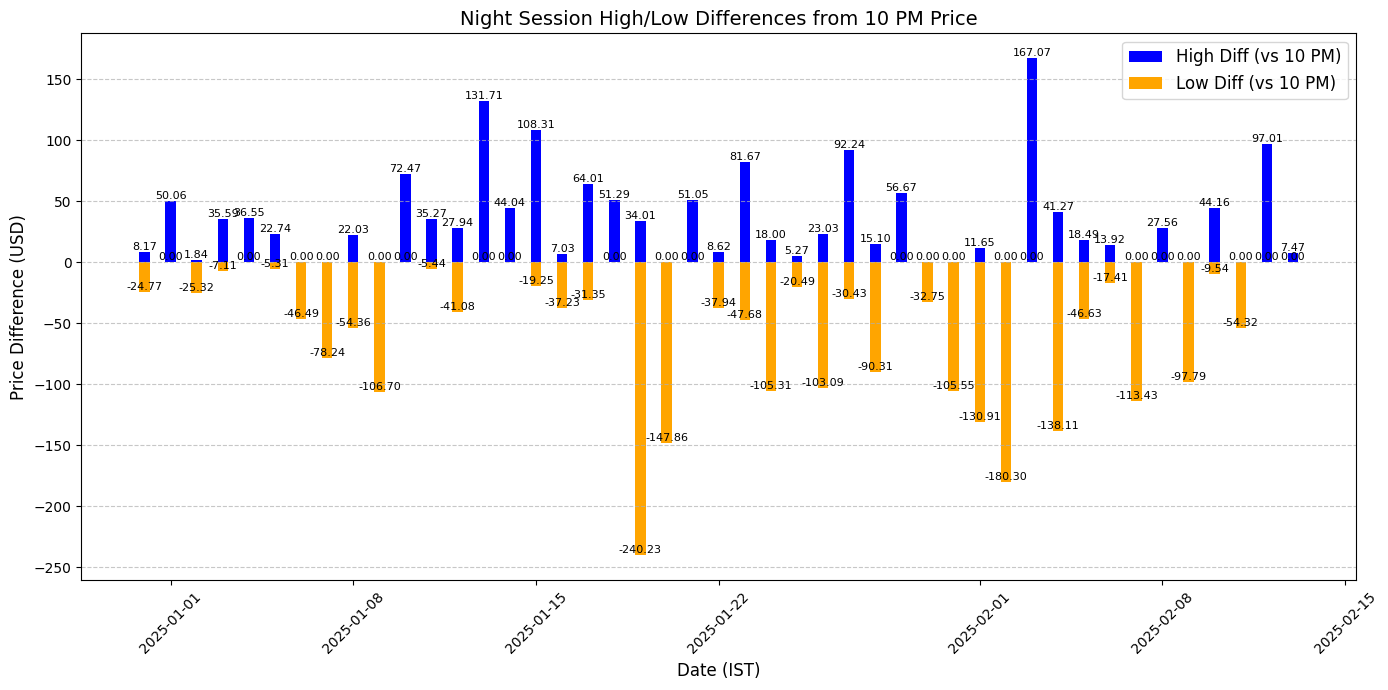

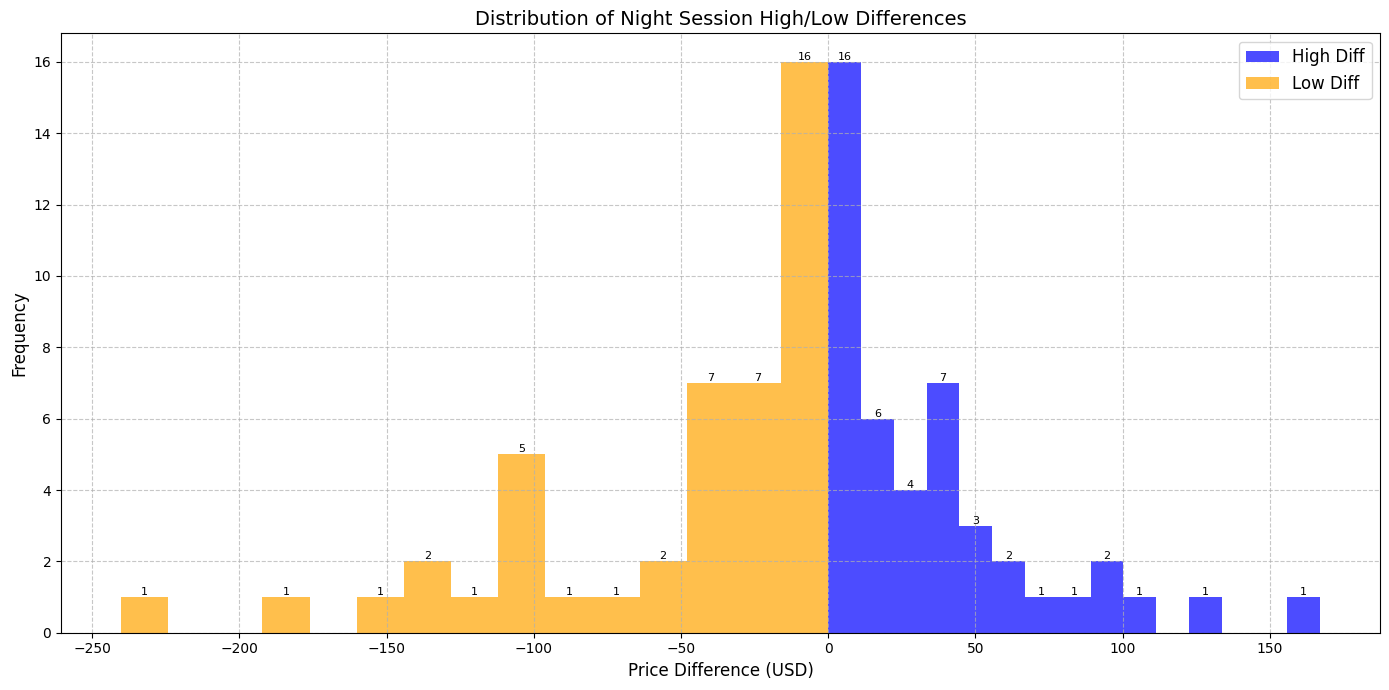

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz

# API parameters
COINGECKO_URL = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart/range"
VS_CURRENCY = "usd"  # Prices in USD
START_DATE = "01-01-2025"  # Start date
END_DATE = datetime.now().strftime("%d-%m-%Y")  # Current date

# Convert date to UTC timestamp
def date_to_utc_timestamp(date_str):
    ist = pytz.timezone('Asia/Kolkata')
    dt = datetime.strptime(date_str, "%d-%m-%Y")
    dt_ist = ist.localize(dt)
    dt_utc = dt_ist.astimezone(pytz.utc)
    return int(dt_utc.timestamp())

# Fetch data from Coingecko
def fetch_ethereum_data(start_ts, end_ts):
    response = requests.get(
        COINGECKO_URL,
        params={'vs_currency': VS_CURRENCY, 'from': start_ts, 'to': end_ts}
    )
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Failed to fetch data: {response.status_code}")

# Process data into DataFrame
def process_data(data):
    df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['datetime_utc'] = df['timestamp'].dt.tz_localize('UTC')
    df['datetime_ist'] = df['datetime_utc'].dt.tz_convert('Asia/Kolkata')
    df['hour_ist'] = df['datetime_ist'].dt.hour
    return df

# Filter data for 10 PM to 7 AM IST
def filter_night_data(df):
    mask = (df['hour_ist'] >= 22) | (df['hour_ist'] < 7)
    df_night = df[mask].copy()
    return df_night

# Calculate high, low, and 10 PM price
def calculate_high_low(df_night):
    def get_group_date(row):
        if row['hour_ist'] >= 22:
            return row['datetime_ist'].date()
        else:
            return (row['datetime_ist'] - timedelta(days=1)).date()

    df_night['group_date'] = df_night.apply(get_group_date, axis=1)
    grouped = df_night.groupby('group_date').agg(
        high=('price', 'max'),
        low=('price', 'min'),
        timestamps=('datetime_ist', list),
        prices=('price', list)
    ).reset_index()

    ten_pm_prices = []
    for idx, row in grouped.iterrows():
        target_time = datetime.combine(row['group_date'], datetime.strptime("22:00", "%H:%M").time())
        target_time = pytz.timezone('Asia/Kolkata').localize(target_time)
        timestamps = row['timestamps']
        if not timestamps:
            ten_pm_prices.append(None)
            continue
        closest_idx = pd.Series(timestamps).sub(target_time).abs().idxmin()
        ten_pm_prices.append(row['prices'][closest_idx])

    grouped['10pm_price'] = ten_pm_prices
    grouped['high_diff'] = grouped['high'] - grouped['10pm_price']
    grouped['low_diff'] = grouped['low'] - grouped['10pm_price']
    return grouped

# Plot results with labels
def plot_results(grouped):
    # Bar chart for daily high/low differences
    plt.figure(figsize=(14, 7))
    bars_high = plt.bar(grouped['group_date'], grouped['high_diff'], width=0.4, label='High Diff (vs 10 PM)', color='blue')
    bars_low = plt.bar(grouped['group_date'], grouped['low_diff'], width=0.4, label='Low Diff (vs 10 PM)', color='orange')

    # Add labels to bars
    for bar in bars_high + bars_low:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=8
        )

    plt.xlabel('Date (IST)', fontsize=12)
    plt.ylabel('Price Difference (USD)', fontsize=12)
    plt.title('Night Session High/Low Differences from 10 PM Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Distribution chart
    plt.figure(figsize=(14, 7))
    counts_high, bins_high, _ = plt.hist(grouped['high_diff'], bins=15, alpha=0.7, label='High Diff', color='blue')
    counts_low, bins_low, _ = plt.hist(grouped['low_diff'], bins=15, alpha=0.7, label='Low Diff', color='orange')

    # Add labels to histogram bars
    for count, bin_edge in zip(counts_high, bins_high):
        if count > 0:
            plt.text(
                bin_edge + (bins_high[1] - bins_high[0]) / 2, count,
                f'{int(count)}', ha='center', va='bottom', fontsize=8
            )
    for count, bin_edge in zip(counts_low, bins_low):
        if count > 0:
            plt.text(
                bin_edge + (bins_low[1] - bins_low[0]) / 2, count,
                f'{int(count)}', ha='center', va='bottom', fontsize=8
            )

    plt.xlabel('Price Difference (USD)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Night Session High/Low Differences', fontsize=14)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Main function
def main():
    start_ts = date_to_utc_timestamp(START_DATE)
    end_ts = date_to_utc_timestamp(END_DATE)

    # Fetch data
    data = fetch_ethereum_data(start_ts, end_ts)

    # Process data
    df = process_data(data)

    # Filter night data
    df_night = filter_night_data(df)

    # Calculate high, low, and 10 PM price
    grouped = calculate_high_low(df_night)

    # Plot results
    plot_results(grouped)

if __name__ == "__main__":
    main()